
    ### Wavelength Analysis Results:
    - **Mean wavelength:** 497.51 nm (appears 0 times)
    - **Median wavelength:** 497.89 nm (appears 435 times)
    - **Top 10 Modes:**
  - 496.33 nm (appears 2001 times)
  - 497.32 nm (appears 1918 times)
  - 498.82 nm (appears 1887 times)
  - 503.33 nm (appears 1840 times)
  - 495.62 nm (appears 1737 times)
  - 494.73 nm (appears 1568 times)
  - 493.06 nm (appears 1484 times)
  - 500.09 nm (appears 1439 times)
  - 499.13 nm (appears 1412 times)
  - 495.11 nm (appears 1233 times)
    - **Minimum wavelength:** 438.73 nm (appears 7 times)
    - **Maximum wavelength:** 520.15 nm (appears 1 times)
    - **Standard deviation:** 5.88 nm
    

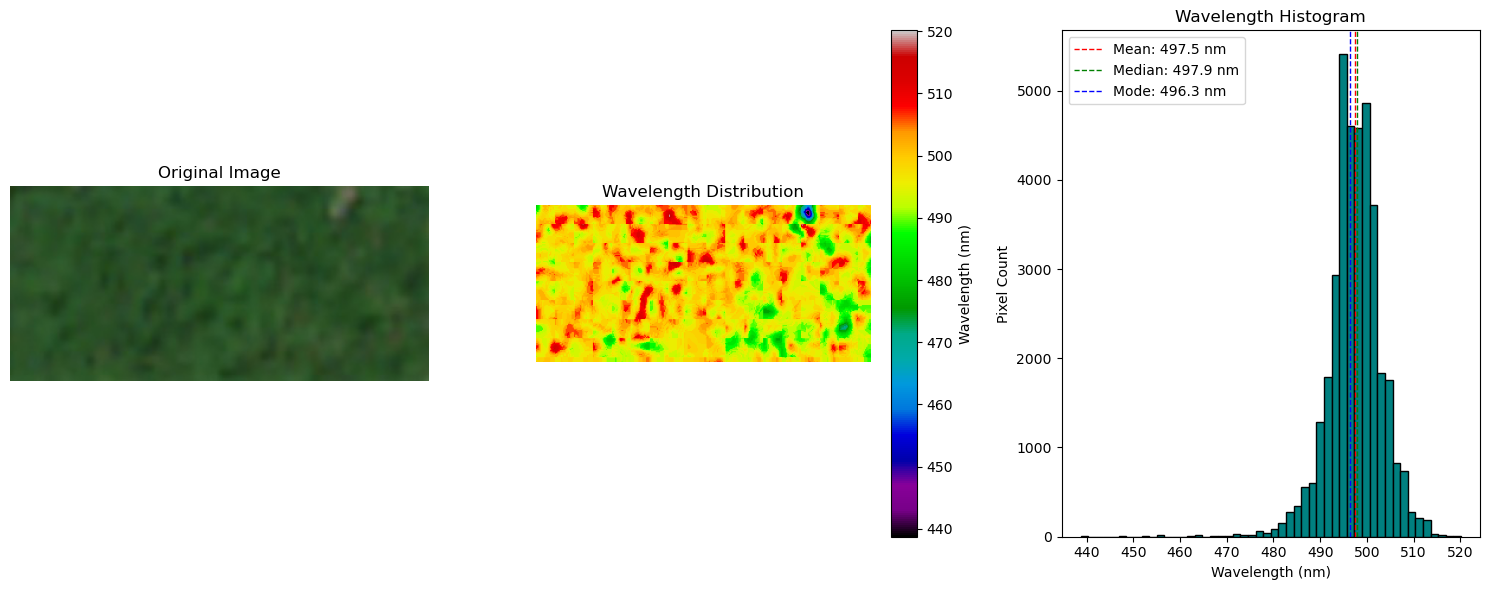

In [2]:
# Import required libraries
import numpy as np
import cv2
from skimage import io
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from scipy import stats
from collections import Counter
from PIL import Image
Image.MAX_IMAGE_PIXELS = None  # Allow large images in Pillow

def rgb_to_wavelength(r, g, b):
    """
    Convert RGB values to approximate wavelength in nanometers.
    This is a simplified approximation using hue-to-wavelength mapping.
    """
    r, g, b = r/255.0, g/255.0, b/255.0
    max_val = max(r, g, b)
    min_val = min(r, g, b)
    diff = max_val - min_val

    # Calculate Hue (0-360 degrees)
    if diff == 0:
        h = 0
    elif max_val == r:
        h = (60 * ((g - b)/diff)) % 360
    elif max_val == g:
        h = (60 * ((b - r)/diff) + 120) % 360
    elif max_val == b:
        h = (60 * ((r - g)/diff) + 240) % 360

    # Normalize hue to 0-1 and map to visible spectrum (380-750 nm)
    normalized_h = h / 360.0
    wavelength = 380 + (normalized_h * 370)

    return wavelength

def analyze_image(image_path):
    """
    Analyze an image and calculate wavelength statistics.
    
    Args:
        image_path: Path to the image file
    
    Returns:
        results: Dictionary containing wavelength statistics
        wavelength_matrix: Matrix of wavelength values
        image: The loaded image
    """
    # Load the image
    image = io.imread(image_path)

    # Convert to RGB if needed
    if len(image.shape) == 2:  # Grayscale
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    elif image.shape[2] == 4:  # RGBA
        image = image[:, :, :3]

    # Calculate wavelengths for all pixels
    height, width = image.shape[:2]
    wavelength_matrix = np.zeros((height, width))

    for y in range(height):
        for x in range(width):
            r, g, b = image[y, x]
            wavelength_matrix[y, x] = rgb_to_wavelength(r, g, b)

    # Flatten and round for stats
    flat_waves = np.round(wavelength_matrix.ravel(), 2)

    # Calculate basic statistics
    mean_val = np.mean(flat_waves)
    median_val = np.median(flat_waves)
    min_val = np.min(flat_waves)
    max_val = np.max(flat_waves)
    std_val = np.std(flat_waves)

    # Count frequency of each wavelength
    wave_counts = Counter(flat_waves)
    top_10_modes = wave_counts.most_common(10)

    # Count appearances for main stats
    results = {
        'mean': (mean_val, np.count_nonzero(flat_waves == round(mean_val, 2))),
        'median': (median_val, np.count_nonzero(flat_waves == round(median_val, 2))),
        'modes': top_10_modes,
        'min': (min_val, np.count_nonzero(flat_waves == round(min_val, 2))),
        'max': (max_val, np.count_nonzero(flat_waves == round(max_val, 2))),
        'std_dev': (std_val, None)
    }

    return results, wavelength_matrix, image

def display_analysis(image_path):
    """Complete analysis and display results in Jupyter Notebook"""
    results, wavelength_matrix, image = analyze_image(image_path)

    # Unpack results
    mean_val, mean_count = results['mean']
    median_val, median_count = results['median']
    modes = results['modes']
    min_val, min_count = results['min']
    max_val, max_count = results['max']
    std_val, _ = results['std_dev']

    # Format top 10 modes
    mode_text = '\n'.join([f"  - {wl:.2f} nm (appears {count} times)" for wl, count in modes])

    # Display statistics
    display(Markdown(f"""
    ### Wavelength Analysis Results:
    - **Mean wavelength:** {mean_val:.2f} nm (appears {mean_count} times)
    - **Median wavelength:** {median_val:.2f} nm (appears {median_count} times)
    - **Top 10 Modes:**
{mode_text}
    - **Minimum wavelength:** {min_val:.2f} nm (appears {min_count} times)
    - **Maximum wavelength:** {max_val:.2f} nm (appears {max_count} times)
    - **Standard deviation:** {std_val:.2f} nm
    """))

    # Create visualizations
    plt.figure(figsize=(15, 6))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Wavelength visualization
    plt.subplot(1, 3, 2)
    wavelength_plot = plt.imshow(wavelength_matrix, cmap='nipy_spectral')
    plt.colorbar(wavelength_plot, label='Wavelength (nm)')
    plt.title('Wavelength Distribution')
    plt.axis('off')

    # Histogram
    plt.subplot(1, 3, 3)
    plt.hist(wavelength_matrix.ravel(), bins=50, color='teal', edgecolor='black')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Pixel Count')
    plt.title('Wavelength Histogram')
    plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_val:.1f} nm')
    plt.axvline(median_val, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_val:.1f} nm')
    plt.axvline(modes[0][0], color='blue', linestyle='dashed', linewidth=1, label=f'Mode: {modes[0][0]:.1f} nm')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return results

# === Run the analysis ===
image_path = "/Users/admin/Downloads/2025-07-03-00_00_2025-07-03-23_59_Sentinel-2_L2A_True_Color.jpg"  # Change this path
results = display_analysis(image_path)



    ### Wavelength Analysis Results:
    - **Mean wavelength:** 504.36 nm (appears 0 times)
    - **Median wavelength:** 504.84 nm (appears 14833 times)
    - **Top 10 Modes:**
  - 504.84 nm (appears 14833 times)
  - 507.96 nm (appears 11514 times)
  - 501.75 nm (appears 11254 times)
  - 503.33 nm (appears 9946 times)
  - 506.27 nm (appears 9250 times)
  - 504.96 nm (appears 8560 times)
  - 501.87 nm (appears 8214 times)
  - 509.21 nm (appears 6564 times)
  - 498.82 nm (appears 5579 times)
  - 508.81 nm (appears 4450 times)
    - **Minimum wavelength:** 474.87 nm (appears 7 times)
    - **Maximum wavelength:** 518.75 nm (appears 2 times)
    - **Standard deviation:** 4.36 nm
    

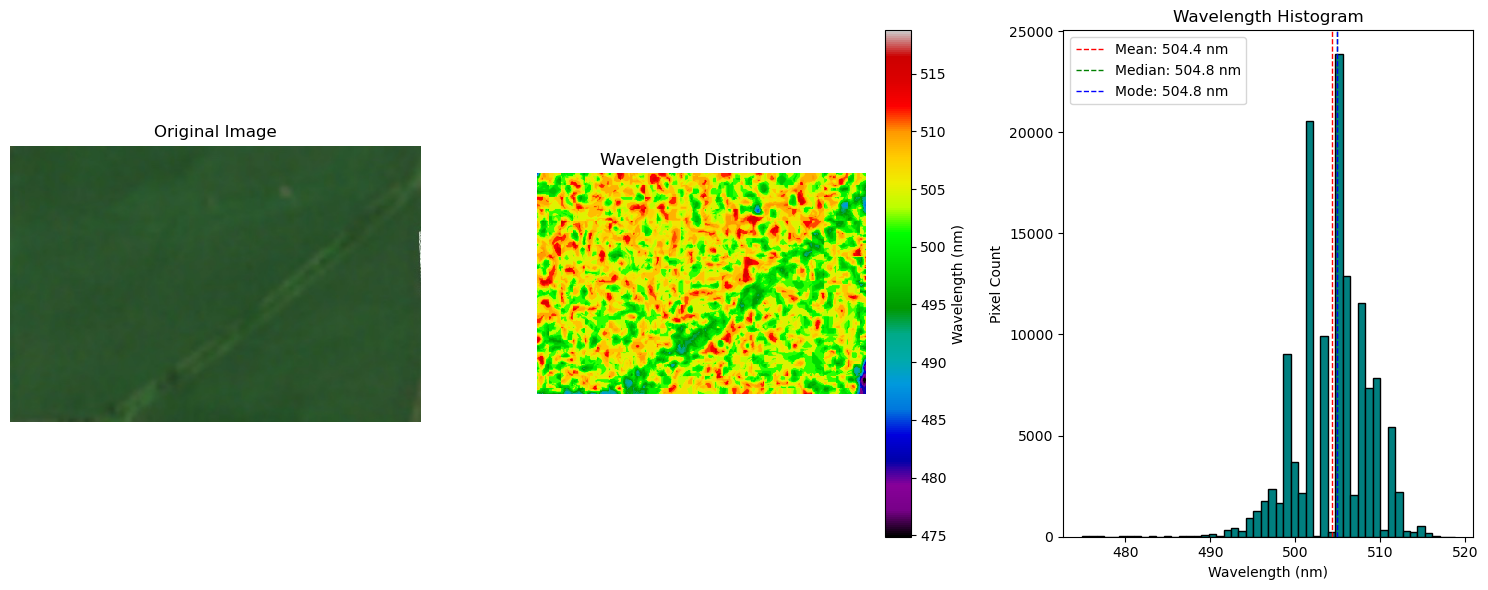

In [4]:
# True Color
image_path = "/Users/admin/Downloads/2025-07-03-00_00_2025-07-03-23_59_Sentinel-2_L2A_True_Color (1).jpg"  # Change this to your image path
results = display_analysis(image_path)


    ### Wavelength Analysis Results:
    - **Mean wavelength:** 478.28 nm (appears 0 times)
    - **Median wavelength:** 478.67 nm (appears 1421 times)
    - **Top 10 Modes:**
  - 478.67 nm (appears 1421 times)
  - 479.11 nm (appears 1148 times)
  - 479.76 nm (appears 1140 times)
  - 479.05 nm (appears 1139 times)
  - 479.44 nm (appears 1001 times)
  - 478.01 nm (appears 946 times)
  - 478.83 nm (appears 937 times)
  - 477.41 nm (appears 871 times)
  - 480.10 nm (appears 811 times)
  - 478.72 nm (appears 655 times)
    - **Minimum wavelength:** 452.88 nm (appears 1 times)
    - **Maximum wavelength:** 482.69 nm (appears 2 times)
    - **Standard deviation:** 1.87 nm
    

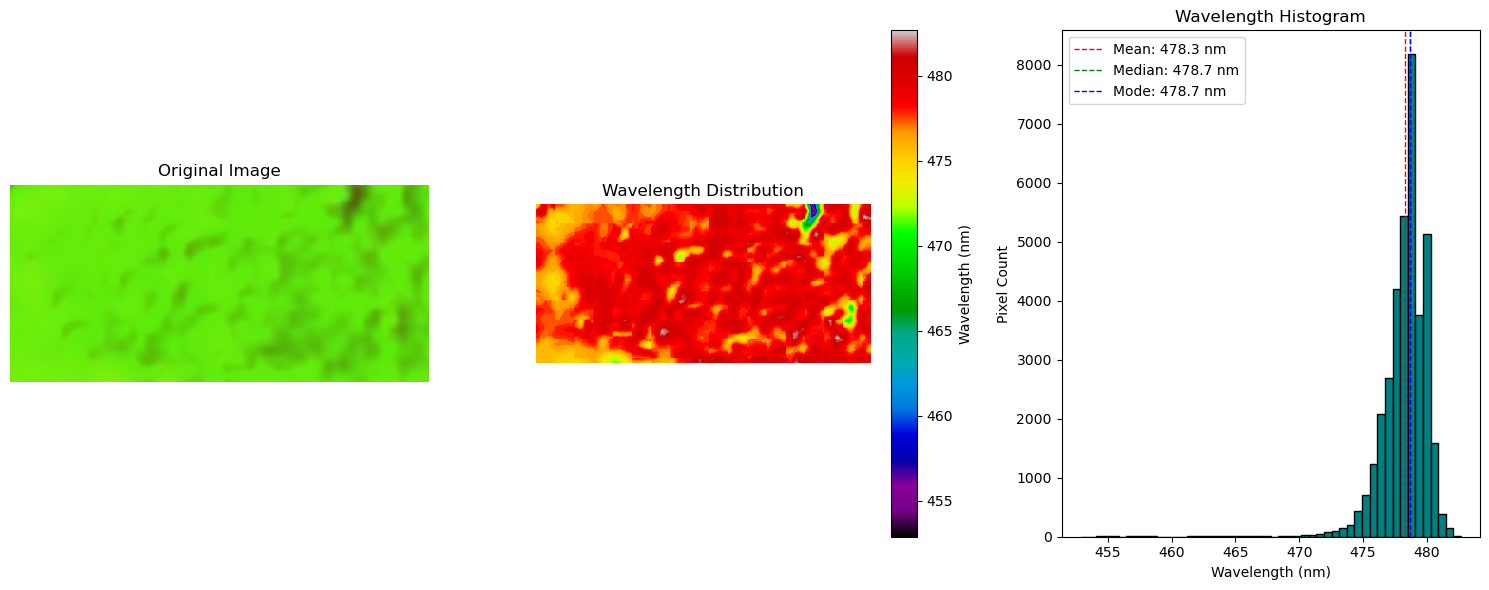

In [6]:
# Agriculture
image_path = "/Users/admin/Downloads/2025-07-03-00_00_2025-07-03-23_59_Sentinel-2_L2A_Agriculture.jpg"  # Change this to your image path
results = display_analysis(image_path)


    ### Wavelength Analysis Results:
    - **Mean wavelength:** 479.28 nm (appears 0 times)
    - **Median wavelength:** 479.59 nm (appears 18128 times)
    - **Top 10 Modes:**
  - 479.05 nm (appears 19002 times)
  - 479.59 nm (appears 18128 times)
  - 479.97 nm (appears 14765 times)
  - 478.67 nm (appears 8939 times)
  - 479.11 nm (appears 7607 times)
  - 479.76 nm (appears 6514 times)
  - 480.34 nm (appears 6384 times)
  - 480.14 nm (appears 6166 times)
  - 478.01 nm (appears 4966 times)
  - 478.72 nm (appears 3448 times)
    - **Minimum wavelength:** 468.88 nm (appears 1 times)
    - **Maximum wavelength:** 483.06 nm (appears 2 times)
    - **Standard deviation:** 1.01 nm
    

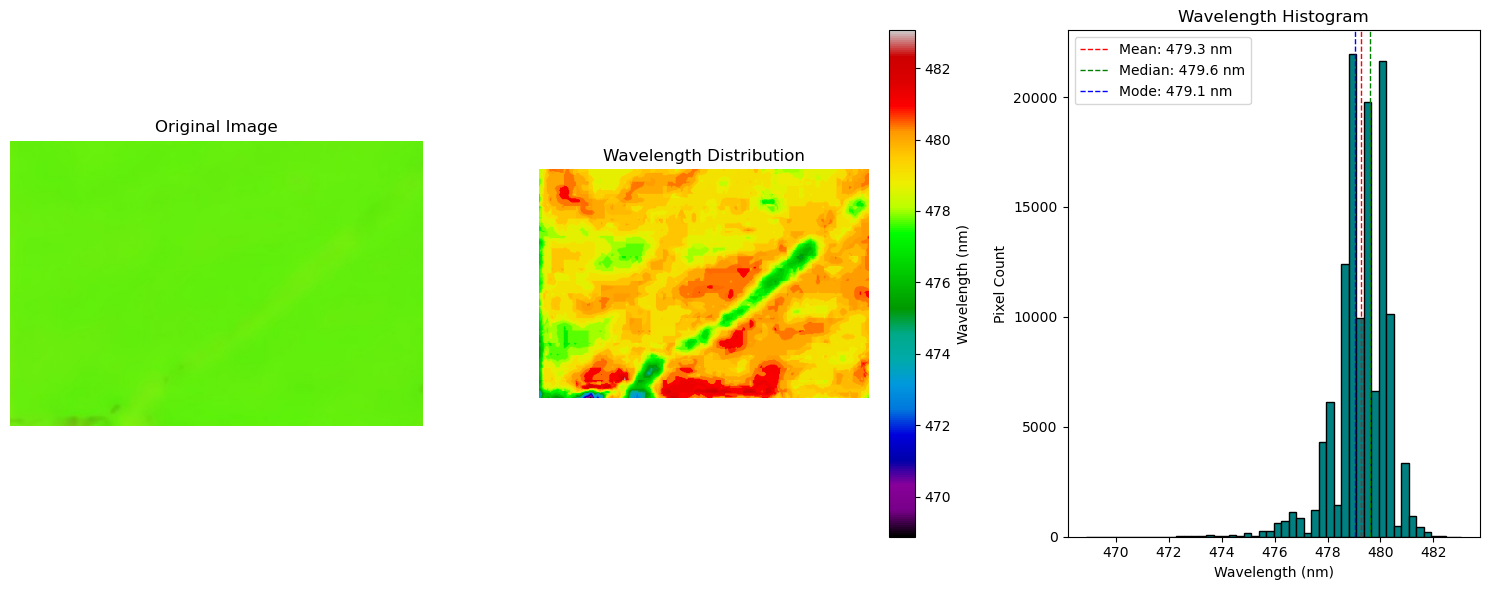

In [10]:
# Agriculture
image_path = "/Users/admin/Downloads/2025-07-03-00_00_2025-07-03-23_59_Sentinel-2_L2A_Agriculture (1).jpg"  # Change this to your image path
results = display_analysis(image_path)


    ### Wavelength Analysis Results:
    - **Mean wavelength:** 528.81 nm (appears 0 times)
    - **Median wavelength:** 528.65 nm (appears 1498 times)
    - **Top 10 Modes:**
  - 528.00 nm (appears 2025 times)
  - 529.86 nm (appears 1770 times)
  - 528.65 nm (appears 1498 times)
  - 528.53 nm (appears 1441 times)
  - 529.37 nm (appears 1247 times)
  - 529.26 nm (appears 1215 times)
  - 528.85 nm (appears 1037 times)
  - 527.35 nm (appears 1030 times)
  - 527.87 nm (appears 988 times)
  - 529.03 nm (appears 973 times)
    - **Minimum wavelength:** 521.77 nm (appears 1 times)
    - **Maximum wavelength:** 552.97 nm (appears 2 times)
    - **Standard deviation:** 2.05 nm
    

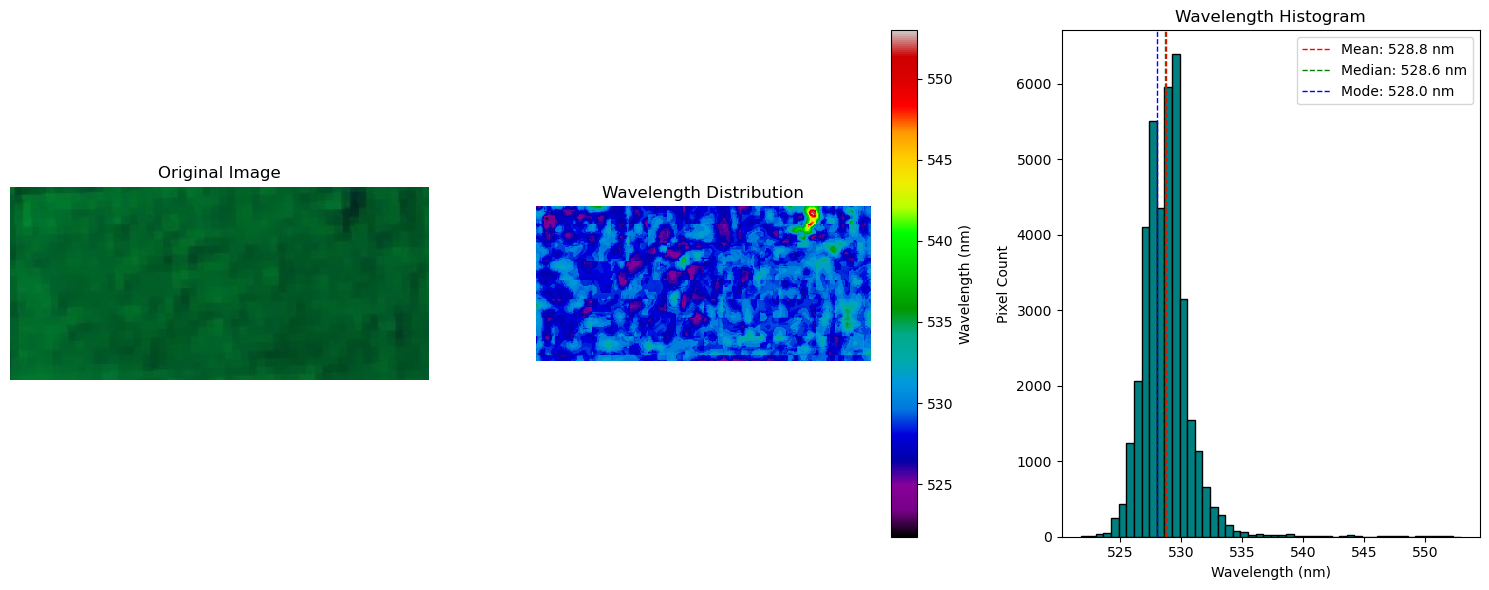

In [12]:
# Barren Soil
image_path = "/Users/admin/Downloads/Barren soil 1.jpg"  # Change this to your image path
results = display_analysis(image_path)


    ### Wavelength Analysis Results:
    - **Mean wavelength:** 525.32 nm (appears 2 times)
    - **Median wavelength:** 525.00 nm (appears 571 times)
    - **Top 10 Modes:**
  - 523.89 nm (appears 9135 times)
  - 525.36 nm (appears 7955 times)
  - 524.78 nm (appears 7814 times)
  - 524.26 nm (appears 6976 times)
  - 526.53 nm (appears 6079 times)
  - 525.81 nm (appears 5233 times)
  - 525.20 nm (appears 5064 times)
  - 523.54 nm (appears 4914 times)
  - 526.60 nm (appears 4617 times)
  - 523.71 nm (appears 4605 times)
    - **Minimum wavelength:** 515.42 nm (appears 1 times)
    - **Maximum wavelength:** 553.21 nm (appears 10 times)
    - **Standard deviation:** 2.47 nm
    

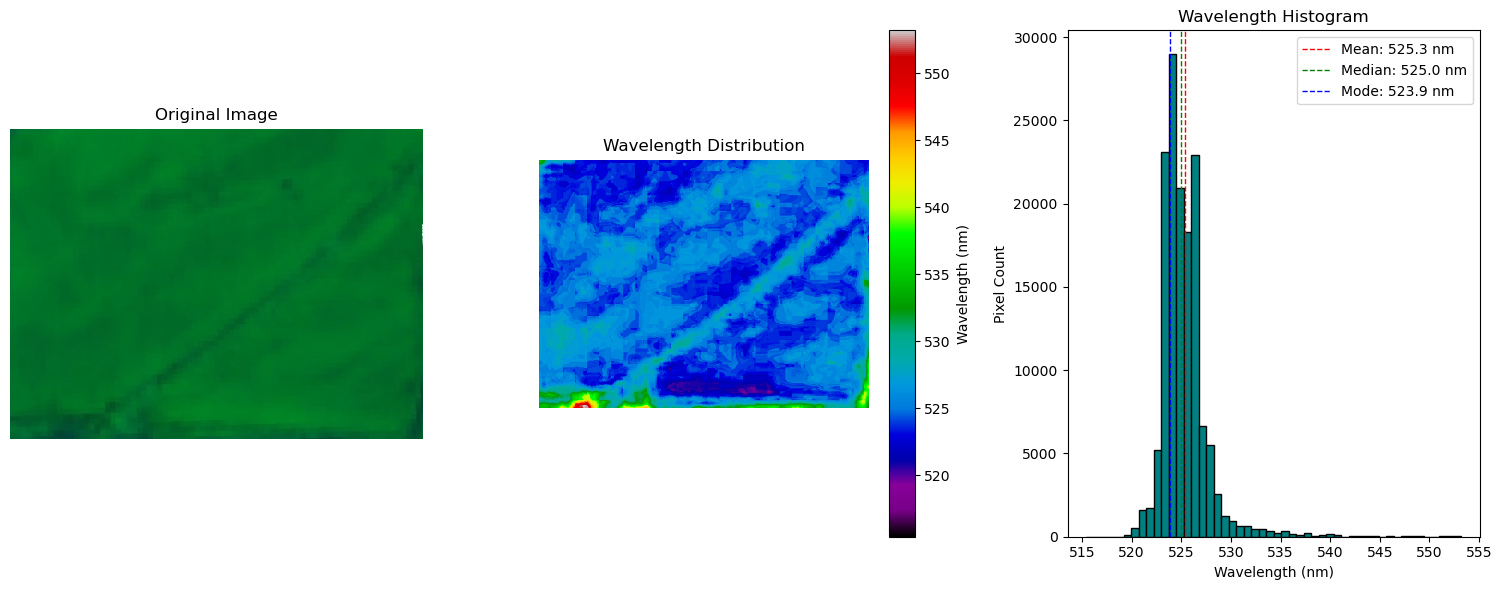

In [14]:
# Barren Soil
image_path = '/Users/admin/Downloads/Barren Soil 2 now.jpg'  # Change this to your image path
results = display_analysis(image_path)


    ### Wavelength Analysis Results:
    - **Mean wavelength:** 501.22 nm (appears 0 times)
    - **Median wavelength:** 503.33 nm (appears 18915 times)
    - **Top 10 Modes:**
  - 503.33 nm (appears 18915 times)
  - 499.86 nm (appears 2822 times)
  - 499.11 nm (appears 2539 times)
  - 501.55 nm (appears 2328 times)
  - 501.62 nm (appears 1467 times)
  - 497.58 nm (appears 997 times)
  - 505.12 nm (appears 717 times)
  - 502.43 nm (appears 648 times)
  - 495.32 nm (appears 632 times)
  - 496.67 nm (appears 611 times)
    - **Minimum wavelength:** 473.42 nm (appears 4 times)
    - **Maximum wavelength:** 507.87 nm (appears 1 times)
    - **Standard deviation:** 3.64 nm
    

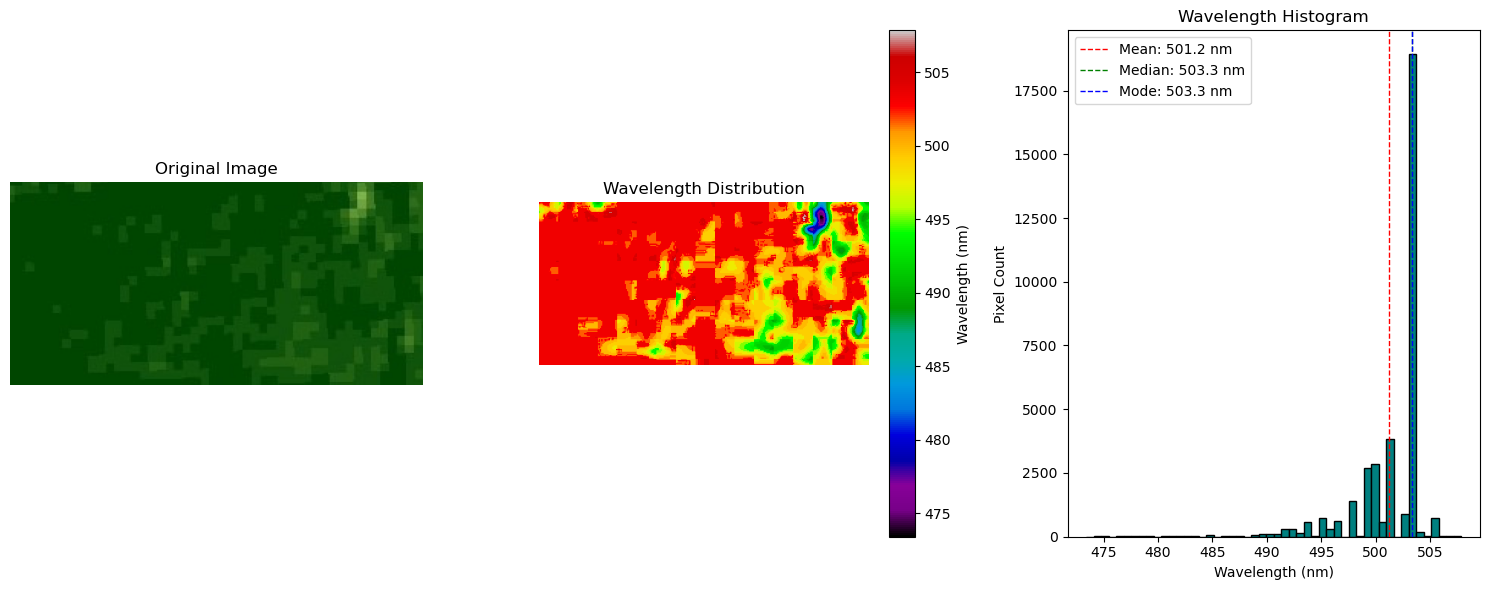

In [16]:
# EVI
image_path = '/Users/admin/Downloads/EVI1.jpg'  # Change this to your image path
results = display_analysis(image_path)


    ### Wavelength Analysis Results:
    - **Mean wavelength:** 503.21 nm (appears 0 times)
    - **Median wavelength:** 503.33 nm (appears 135232 times)
    - **Top 10 Modes:**
  - 503.33 nm (appears 135232 times)
  - 505.12 nm (appears 589 times)
  - 499.11 nm (appears 563 times)
  - 501.55 nm (appears 526 times)
  - 501.62 nm (appears 478 times)
  - 499.86 nm (appears 438 times)
  - 500.80 nm (appears 223 times)
  - 497.58 nm (appears 168 times)
  - 502.43 nm (appears 157 times)
  - 491.77 nm (appears 113 times)
    - **Minimum wavelength:** 482.78 nm (appears 1 times)
    - **Maximum wavelength:** 506.91 nm (appears 9 times)
    - **Standard deviation:** 1.04 nm
    

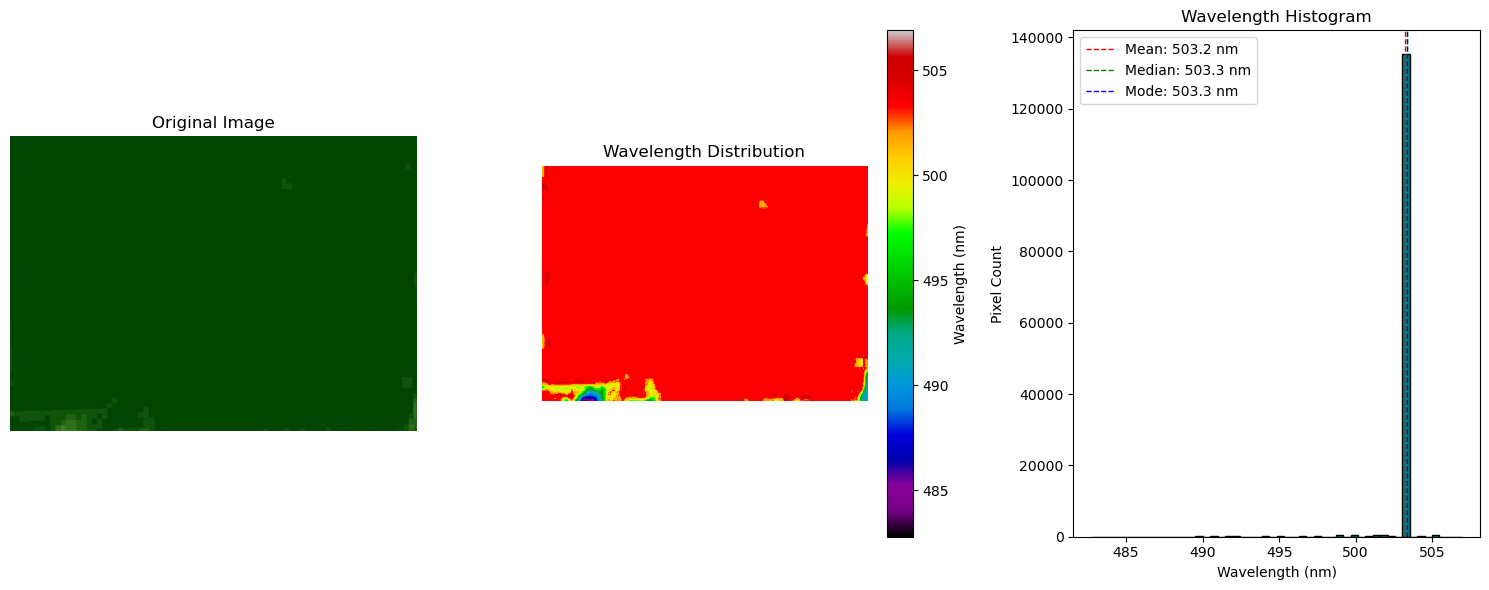

In [18]:
# EVI
image_path = '/Users/admin/Downloads/EVI2.jpg'  # Change this to your image path
results = display_analysis(image_path)


    ### Wavelength Analysis Results:
    - **Mean wavelength:** 559.56 nm (appears 2653 times)
    - **Median wavelength:** 559.55 nm (appears 2236 times)
    - **Top 10 Modes:**
  - 559.51 nm (appears 3535 times)
  - 559.48 nm (appears 3441 times)
  - 559.57 nm (appears 3386 times)
  - 559.53 nm (appears 3382 times)
  - 559.45 nm (appears 3245 times)
  - 559.65 nm (appears 3217 times)
  - 559.64 nm (appears 3153 times)
  - 559.49 nm (appears 3134 times)
  - 559.47 nm (appears 3115 times)
  - 559.58 nm (appears 3115 times)
    - **Minimum wavelength:** 558.76 nm (appears 34 times)
    - **Maximum wavelength:** 560.77 nm (appears 35 times)
    - **Standard deviation:** 0.22 nm
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.3829787..0.5284].


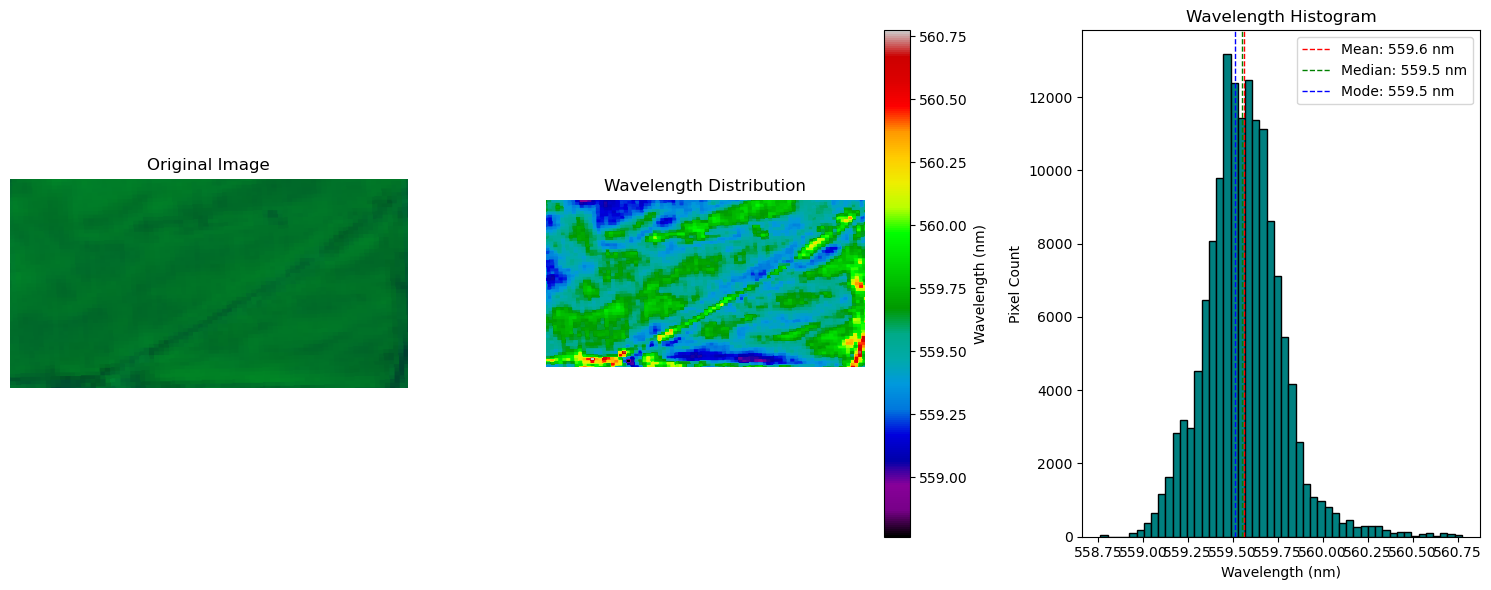

In [20]:
# Barren Soil Forest Tiff image 
image_path = '/Users/admin/Downloads/Barren Soil 3.tiff'  # Change this to your image path
results = display_analysis(image_path)


    ### Wavelength Analysis Results:
    - **Mean wavelength:** 545.20 nm (appears 0 times)
    - **Median wavelength:** 527.61 nm (appears 129 times)
    - **Top 10 Modes:**
  - 523.89 nm (appears 31998 times)
  - 525.36 nm (appears 27294 times)
  - 524.78 nm (appears 21841 times)
  - 523.54 nm (appears 20204 times)
  - 525.13 nm (appears 17435 times)
  - 526.53 nm (appears 16722 times)
  - 534.17 nm (appears 16379 times)
  - 528.00 nm (appears 15695 times)
  - 524.26 nm (appears 14456 times)
  - 526.67 nm (appears 13555 times)
    - **Minimum wavelength:** 380.00 nm (appears 4256 times)
    - **Maximum wavelength:** 749.75 nm (appears 7 times)
    - **Standard deviation:** 59.29 nm
    

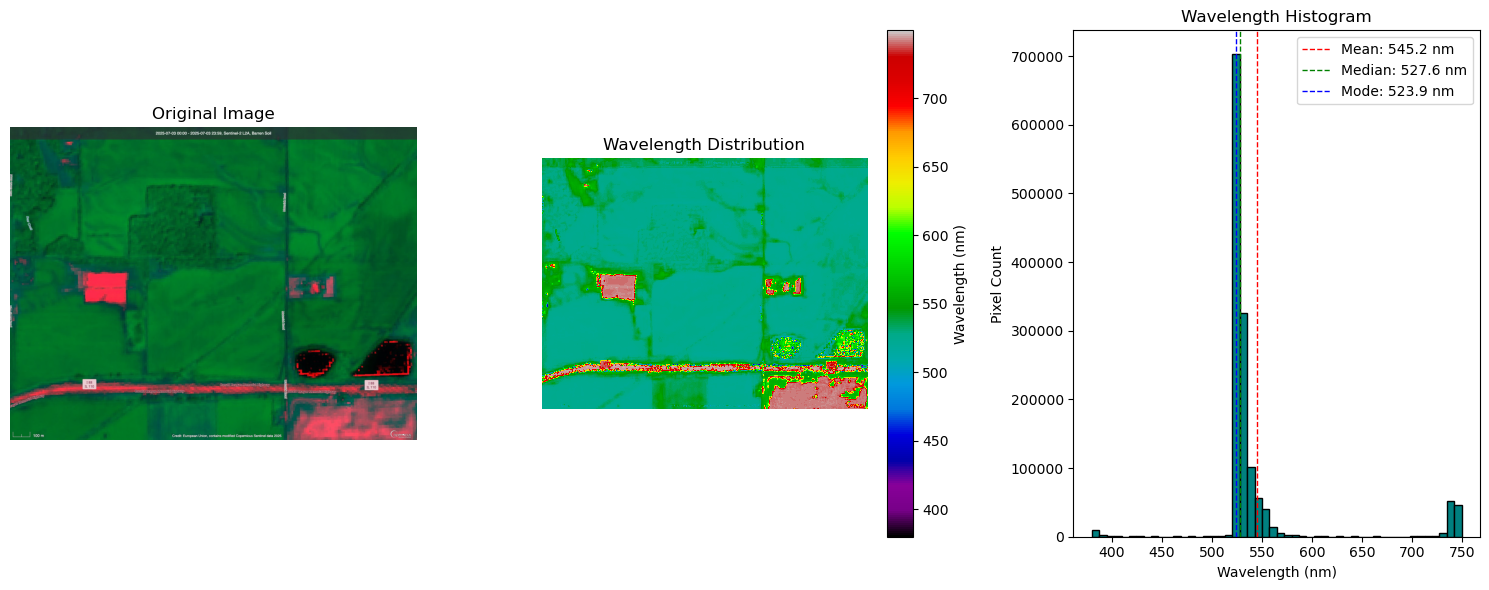

In [22]:
# Barren Soil
image_path = '/Users/admin/Downloads/Barren Soil Low Res.jpg'  # Change this to your image path
results = display_analysis(image_path)


    ### Wavelength Analysis Results:
    - **Mean wavelength:** 508.75 nm (appears 0 times)
    - **Median wavelength:** 508.70 nm (appears 667 times)
    - **Top 10 Modes:**
  - 508.47 nm (appears 1110 times)
  - 509.18 nm (appears 886 times)
  - 508.63 nm (appears 833 times)
  - 507.93 nm (appears 772 times)
  - 508.19 nm (appears 770 times)
  - 508.91 nm (appears 736 times)
  - 508.24 nm (appears 697 times)
  - 507.74 nm (appears 695 times)
  - 508.16 nm (appears 667 times)
  - 508.70 nm (appears 667 times)
    - **Minimum wavelength:** 503.33 nm (appears 1 times)
    - **Maximum wavelength:** 520.09 nm (appears 2 times)
    - **Standard deviation:** 1.01 nm
    

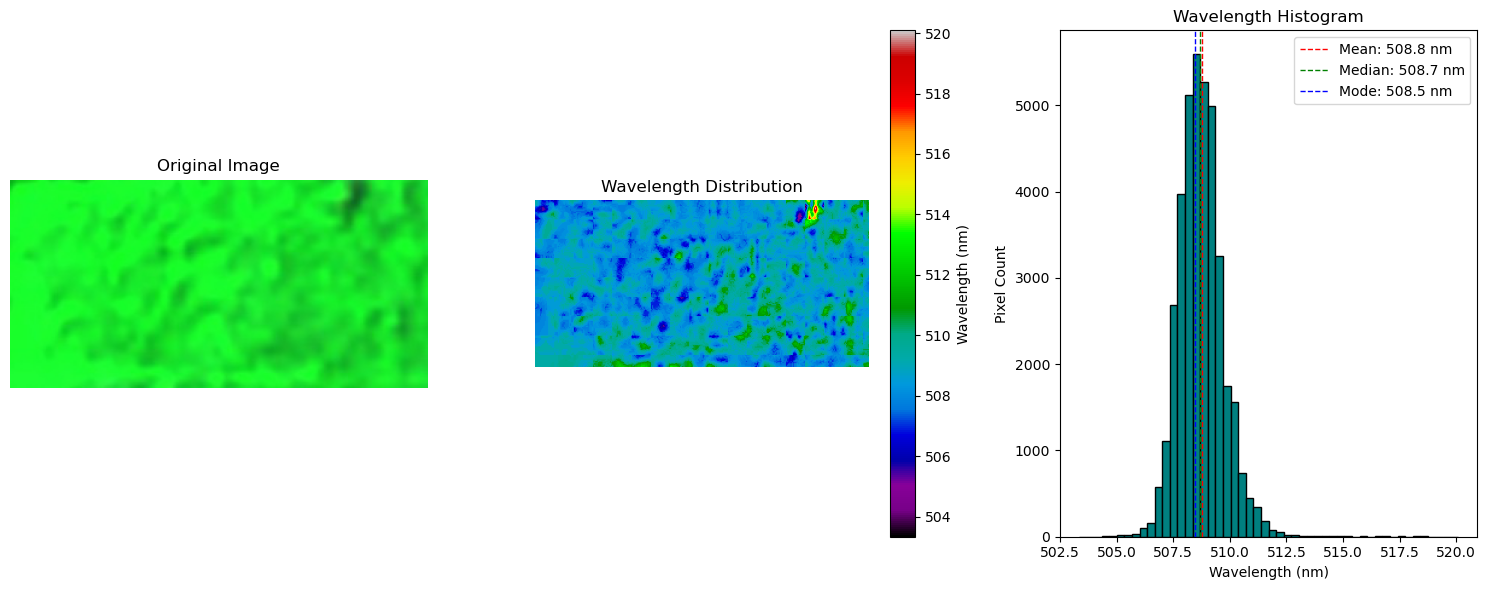

In [24]:
# Custom Layer Forest (B03, B08, B05)
image_path = '/Users/admin/Downloads/Custom Layer Forest.jpg'  # Change this to your image path
results = display_analysis(image_path)



    ### Wavelength Analysis Results:
    - **Mean wavelength:** 506.07 nm (appears 0 times)
    - **Median wavelength:** 505.48 nm (appears 63905 times)
    - **Top 10 Modes:**
  - 505.48 nm (appears 63905 times)
  - 505.21 nm (appears 22278 times)
  - 505.23 nm (appears 9708 times)
  - 506.01 nm (appears 8520 times)
  - 505.77 nm (appears 7207 times)
  - 506.56 nm (appears 1644 times)
  - 505.46 nm (appears 1553 times)
  - 505.73 nm (appears 1380 times)
  - 507.10 nm (appears 1123 times)
  - 504.95 nm (appears 1032 times)
    - **Minimum wavelength:** 380.00 nm (appears 2 times)
    - **Maximum wavelength:** 729.44 nm (appears 1 times)
    - **Standard deviation:** 2.51 nm
    

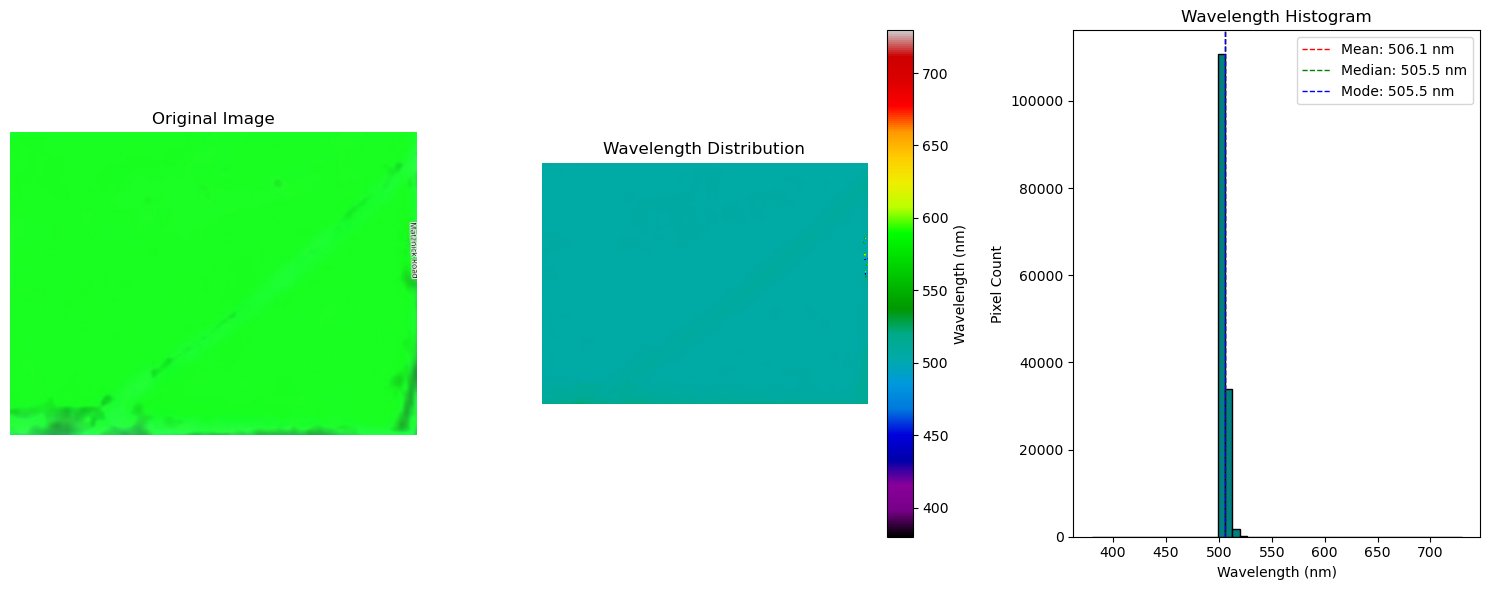

In [26]:
# Custom (B03, B08, B05)
image_path = '/Users/admin/Downloads/Custom Layer Corn.jpg'  # Change this to your image path
results = display_analysis(image_path)


In [ ]:
#This is testing part

In [ ]:
#This is Barren Soil Layer  test

Pixels near target wavelengths ±1.0 nm: 643271


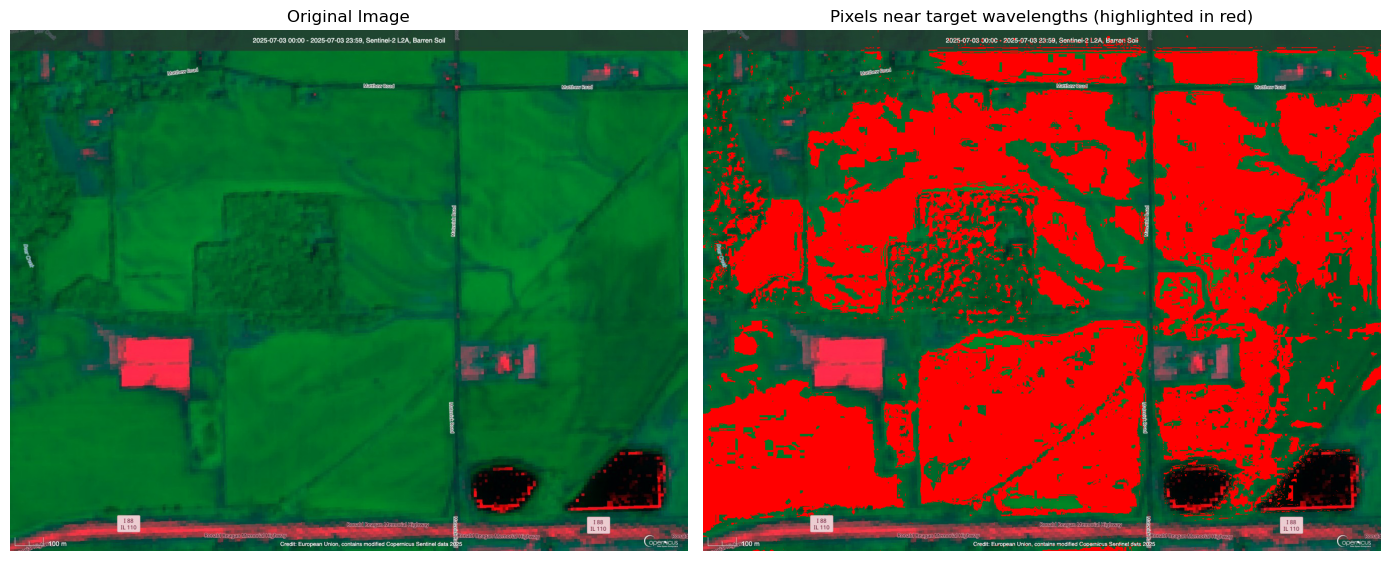

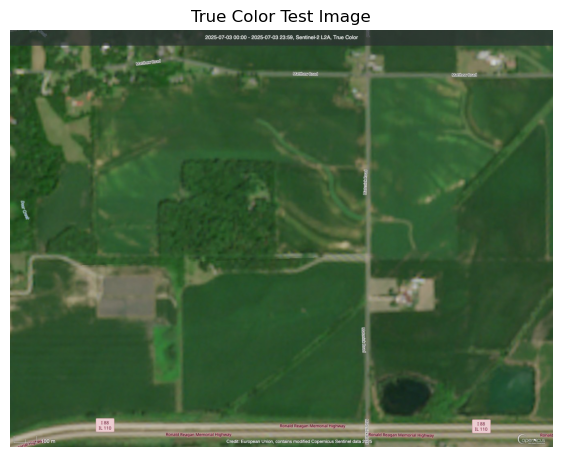

In [30]:
# === Define function to convert RGB to wavelength ===
def rgb_to_wavelength(r, g, b):
    """
    Convert RGB values to approximate wavelength in nanometers.
    Simplified approximation using hue-to-wavelength mapping.
    """
    r, g, b = r/255.0, g/255.0, b/255.0
    max_val = max(r, g, b)
    min_val = min(r, g, b)
    diff = max_val - min_val

    if diff == 0:
        h = 0
    elif max_val == r:
        h = (60 * ((g - b)/diff)) % 360
    elif max_val == g:
        h = (60 * ((b - r)/diff) + 120) % 360
    elif max_val == b:
        h = (60 * ((r - g)/diff) + 240) % 360

    # Map hue (0–360) to wavelength (380–750 nm)
    normalized_h = h / 360.0
    wavelength = 380 + (normalized_h * 370)
    return wavelength

# === Define function to highlight pixels based on multiple target wavelengths ===
def highlight_wavelength_pixels(image_path, target_wavelengths, tolerance):
    """
    Highlights pixels in the image that correspond to the given target wavelengths.
    """
    # Load image
    image = io.imread(image_path)

    # Convert RGBA to RGB if needed
    if image.shape[-1] == 4:
        image = image[:, :, :3]

    height, width, _ = image.shape
    highlight_mask = np.zeros((height, width), dtype=bool)

    # Compute wavelength for each pixel and mask pixels within the range
    for y in range(height):
        for x in range(width):
            r, g, b = image[y, x]
            wl = rgb_to_wavelength(r, g, b)
            for target_wavelength in target_wavelengths:
                if abs(wl - target_wavelength) <= tolerance:
                    highlight_mask[y, x] = True
                    break  # Stop checking if one match found

    # Create highlighted image (mark matching pixels in red)
    highlighted_image = image.copy()
    highlighted_image[highlight_mask] = [255, 0, 0]  # Red

    # Count and print result
    count = np.sum(highlight_mask)
    print(f"Pixels near target wavelengths ±{tolerance} nm: {count}")

    # Display images
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(highlighted_image)
    plt.title('Pixels near target wavelengths (highlighted in red)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return highlighted_image, highlight_mask

# === Define list of target wavelengths ===
target_wavelengths = [
    523.89,
    525.36,
    524.78,
    524.26,
    526.53,
    525.81,
    525.20,
    526.60,
    523.54,
    523.71
]

# === Set image path and run the function ===
image_path = "/Users/admin/Downloads/Barren Soil test image.jpg"  # Replace with your image path
highlighted_image, mask = highlight_wavelength_pixels(image_path, target_wavelengths, tolerance=1.0)

# === Display the true color image within the notebook ===
truecolor_image_path = "/Users/admin/Downloads/True Color Test Image.jpg"
truecolor_image = Image.open(truecolor_image_path)

plt.figure(figsize=(7, 6))
plt.imshow(truecolor_image)
plt.title('True Color Test Image')
plt.axis('off')
plt.show()


In [ ]:
#This is True color Test

Pixels near target wavelengths ±1.0 nm: 539827


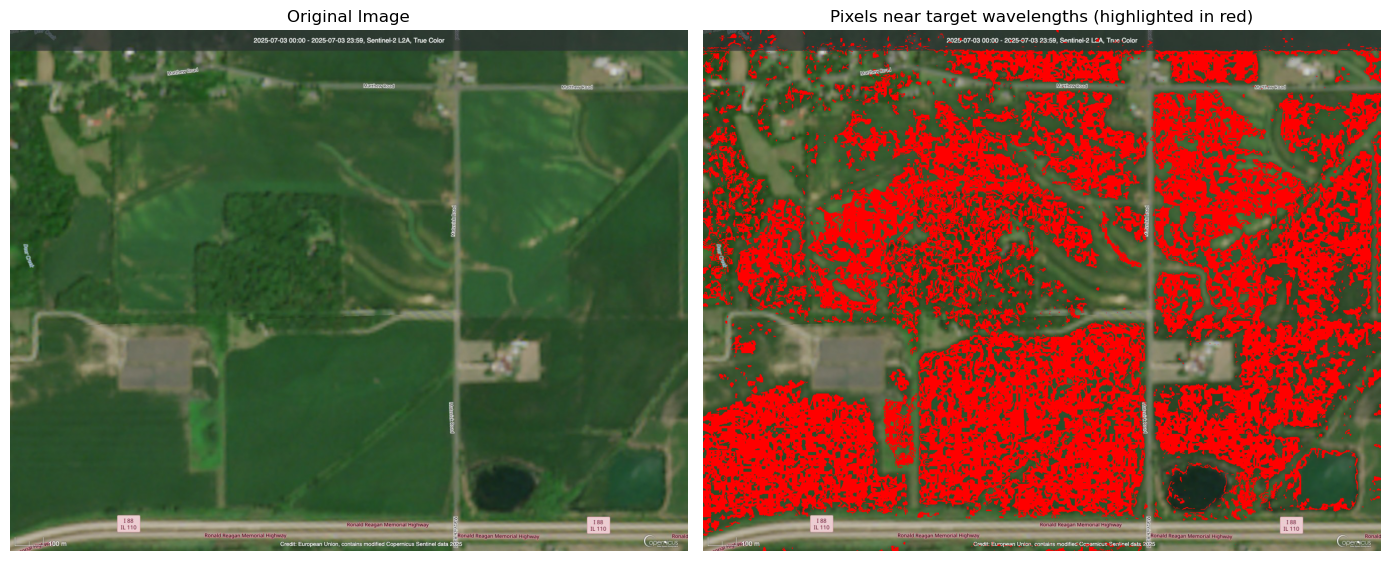

In [31]:
# === Import required libraries ===
import numpy as np
import cv2
from skimage import io
import matplotlib.pyplot as plt
from PIL import Image
Image.MAX_IMAGE_PIXELS = None  # Allow large images in Pillow

# === Define function to convert RGB to wavelength ===
def rgb_to_wavelength(r, g, b):
    """
    Convert RGB values to approximate wavelength in nanometers.
    Simplified approximation using hue-to-wavelength mapping.
    """
    r, g, b = r/255.0, g/255.0, b/255.0
    max_val = max(r, g, b)
    min_val = min(r, g, b)
    diff = max_val - min_val

    if diff == 0:
        h = 0
    elif max_val == r:
        h = (60 * ((g - b)/diff)) % 360
    elif max_val == g:
        h = (60 * ((b - r)/diff) + 120) % 360
    elif max_val == b:
        h = (60 * ((r - g)/diff) + 240) % 360

    # Map hue (0–360) to wavelength (380–750 nm)
    normalized_h = h / 360.0
    wavelength = 380 + (normalized_h * 370)
    return wavelength

# === Define function to highlight pixels based on multiple target wavelengths ===
def highlight_wavelength_pixels(image_path, target_wavelengths, tolerance):
    """
    Highlights pixels in the image that correspond to the given target wavelengths.
    """
    # Load image
    image = io.imread(image_path)

    # Convert RGBA to RGB if needed
    if image.shape[-1] == 4:
        image = image[:, :, :3]

    height, width, _ = image.shape
    highlight_mask = np.zeros((height, width), dtype=bool)

    # Compute wavelength for each pixel and mask pixels within the range
    for y in range(height):
        for x in range(width):
            r, g, b = image[y, x]
            wl = rgb_to_wavelength(r, g, b)
            for target_wavelength in target_wavelengths:
                if abs(wl - target_wavelength) <= tolerance:
                    highlight_mask[y, x] = True
                    break  # Stop checking if one match found

    # Create highlighted image (mark matching pixels in red)
    highlighted_image = image.copy()
    highlighted_image[highlight_mask] = [255, 0, 0]  # Red

    # Count and print result
    count = np.sum(highlight_mask)
    print(f"Pixels near target wavelengths ±{tolerance} nm: {count}")

    # Display images
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(highlighted_image)
    plt.title('Pixels near target wavelengths (highlighted in red)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return highlighted_image, highlight_mask

# === Define list of target wavelengths ===
target_wavelengths = [
    504.89,
    501.75,
    507.96,
    503.33,
    506.27,
    504.96,
    501.87,
    498.82
]

# === Set image path and run the function ===
image_path = "/Users/admin/Downloads/True Color Test Im.jpg"  # Replace with your image path
highlighted_image, mask = highlight_wavelength_pixels(image_path, target_wavelengths, tolerance=1.0)

In [ ]:
# Agriculture Layer Test 

Pixels near target wavelengths ±1.0 nm: 767968


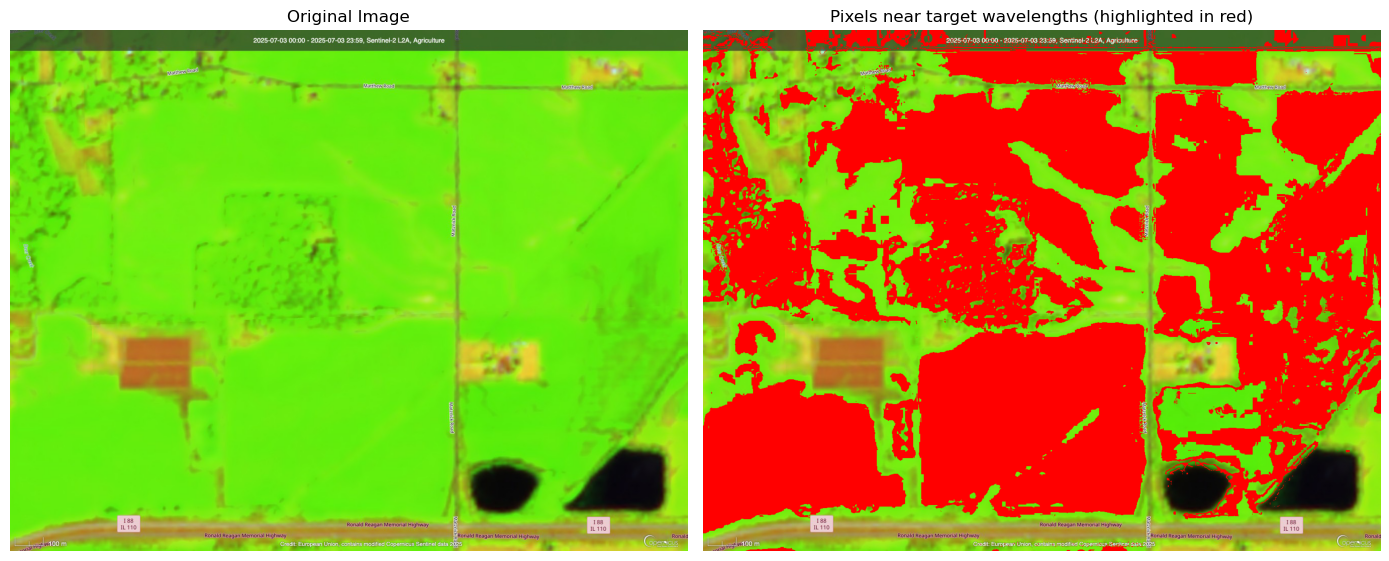

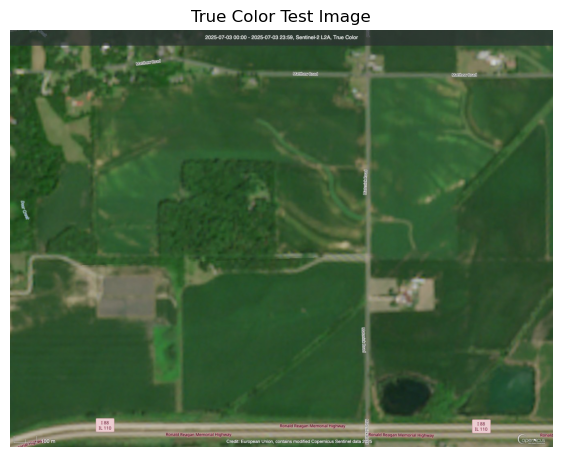

In [34]:
# === Define function to convert RGB to wavelength ===
def rgb_to_wavelength(r, g, b):
    """
    Convert RGB values to approximate wavelength in nanometers.
    Simplified approximation using hue-to-wavelength mapping.
    """
    r, g, b = r/255.0, g/255.0, b/255.0
    max_val = max(r, g, b)
    min_val = min(r, g, b)
    diff = max_val - min_val

    if diff == 0:
        h = 0
    elif max_val == r:
        h = (60 * ((g - b)/diff)) % 360
    elif max_val == g:
        h = (60 * ((b - r)/diff) + 120) % 360
    elif max_val == b:
        h = (60 * ((r - g)/diff) + 240) % 360

    # Map hue (0–360) to wavelength (380–750 nm)
    normalized_h = h / 360.0
    wavelength = 380 + (normalized_h * 370)
    return wavelength

# === Define function to highlight pixels based on multiple target wavelengths ===
def highlight_wavelength_pixels(image_path, target_wavelengths, tolerance):
    """
    Highlights pixels in the image that correspond to the given target wavelengths.
    """
    # Load image
    image = io.imread(image_path)

    # Convert RGBA to RGB if needed
    if image.shape[-1] == 4:
        image = image[:, :, :3]

    height, width, _ = image.shape
    highlight_mask = np.zeros((height, width), dtype=bool)

    # Compute wavelength for each pixel and mask pixels within the range
    for y in range(height):
        for x in range(width):
            r, g, b = image[y, x]
            wl = rgb_to_wavelength(r, g, b)
            for target_wavelength in target_wavelengths:
                if abs(wl - target_wavelength) <= tolerance:
                    highlight_mask[y, x] = True
                    break  # Stop checking if one match found

    # Create highlighted image (mark matching pixels in red)
    highlighted_image = image.copy()
    highlighted_image[highlight_mask] = [255, 0, 0]  # Red

    # Count and print result
    count = np.sum(highlight_mask)
    print(f"Pixels near target wavelengths ±{tolerance} nm: {count}")

    # Display images
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(highlighted_image)
    plt.title('Pixels near target wavelengths (highlighted in red)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return highlighted_image, highlight_mask

# === Define list of target wavelengths ===
target_wavelengths = [
    479.05,
    479.59,
    479.97,
    478.67, 
    480.34,
    480.14,
    479.11,
    479.76,
    478.01,
    478.72
]

# === Set image path and run the function ===
image_path = "/Users/admin/Downloads/Agriculture Test Im.jpg"  # Replace with your image path
highlighted_image, mask = highlight_wavelength_pixels(image_path, target_wavelengths, tolerance=1.0)

# === Display the true color image within the notebook ===
truecolor_image_path = "/Users/admin/Downloads/True Color Test Image.jpg"
truecolor_image = Image.open(truecolor_image_path)

plt.figure(figsize=(7, 6))
plt.imshow(truecolor_image)
plt.title('True Color Test Image')
plt.axis('off')
plt.show()


In [ ]:
# EVI Layer Test

Pixels near target wavelengths ±1.0 nm: 937020


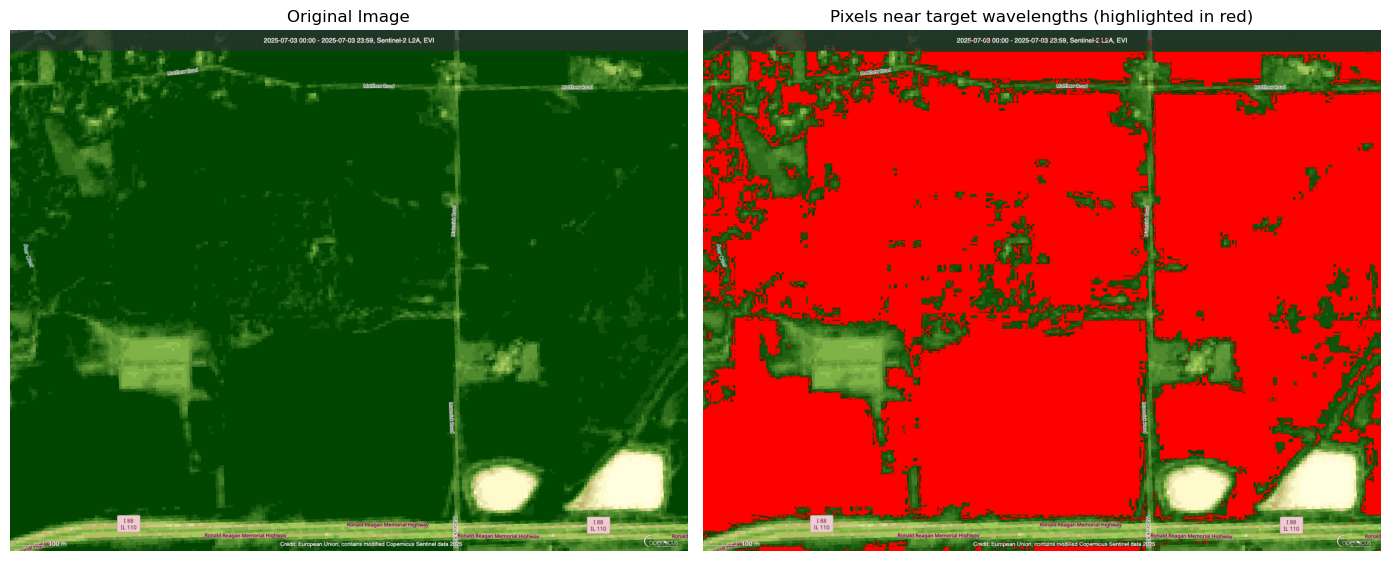

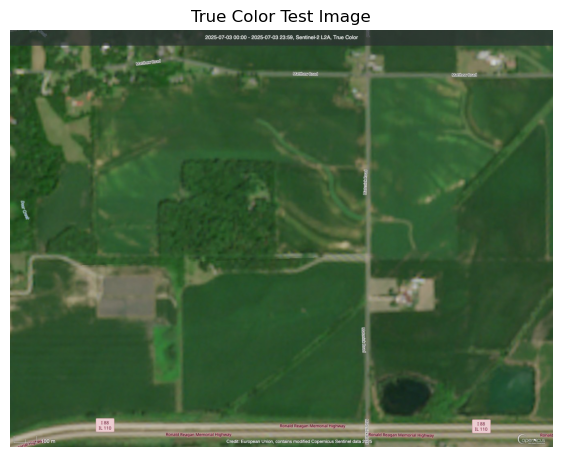

In [36]:
# === Define function to convert RGB to wavelength ===
def rgb_to_wavelength(r, g, b):
    """
    Convert RGB values to approximate wavelength in nanometers.
    Simplified approximation using hue-to-wavelength mapping.
    """
    r, g, b = r/255.0, g/255.0, b/255.0
    max_val = max(r, g, b)
    min_val = min(r, g, b)
    diff = max_val - min_val

    if diff == 0:
        h = 0
    elif max_val == r:
        h = (60 * ((g - b)/diff)) % 360
    elif max_val == g:
        h = (60 * ((b - r)/diff) + 120) % 360
    elif max_val == b:
        h = (60 * ((r - g)/diff) + 240) % 360

    # Map hue (0–360) to wavelength (380–750 nm)
    normalized_h = h / 360.0
    wavelength = 380 + (normalized_h * 370)
    return wavelength

# === Define function to highlight pixels based on multiple target wavelengths ===
def highlight_wavelength_pixels(image_path, target_wavelengths, tolerance):
    """
    Highlights pixels in the image that correspond to the given target wavelengths.
    """
    # Load image
    image = io.imread(image_path)

    # Convert RGBA to RGB if needed
    if image.shape[-1] == 4:
        image = image[:, :, :3]

    height, width, _ = image.shape
    highlight_mask = np.zeros((height, width), dtype=bool)

    # Compute wavelength for each pixel and mask pixels within the range
    for y in range(height):
        for x in range(width):
            r, g, b = image[y, x]
            wl = rgb_to_wavelength(r, g, b)
            for target_wavelength in target_wavelengths:
                if abs(wl - target_wavelength) <= tolerance:
                    highlight_mask[y, x] = True
                    break  # Stop checking if one match found

    # Create highlighted image (mark matching pixels in red)
    highlighted_image = image.copy()
    highlighted_image[highlight_mask] = [255, 0, 0]  # Red

    # Count and print result
    count = np.sum(highlight_mask)
    print(f"Pixels near target wavelengths ±{tolerance} nm: {count}")

    # Display images
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(highlighted_image)
    plt.title('Pixels near target wavelengths (highlighted in red)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return highlighted_image, highlight_mask

# === Define list of target wavelengths ===
target_wavelengths = [
    503.33
]

# === Set image path and run the function ===
image_path = "/Users/admin/Downloads/EVI Test Im.jpg"  # Replace with your image path
highlighted_image, mask = highlight_wavelength_pixels(image_path, target_wavelengths, tolerance=1.0)

# === Display the true color image within the notebook ===
truecolor_image_path = "/Users/admin/Downloads/True Color Test Image.jpg"
truecolor_image = Image.open(truecolor_image_path)

plt.figure(figsize=(7, 6))
plt.imshow(truecolor_image)
plt.title('True Color Test Image')
plt.axis('off')
plt.show()

In [ ]:
# Custom Layer Test

Pixels near target wavelengths ±1.0 nm: 722794


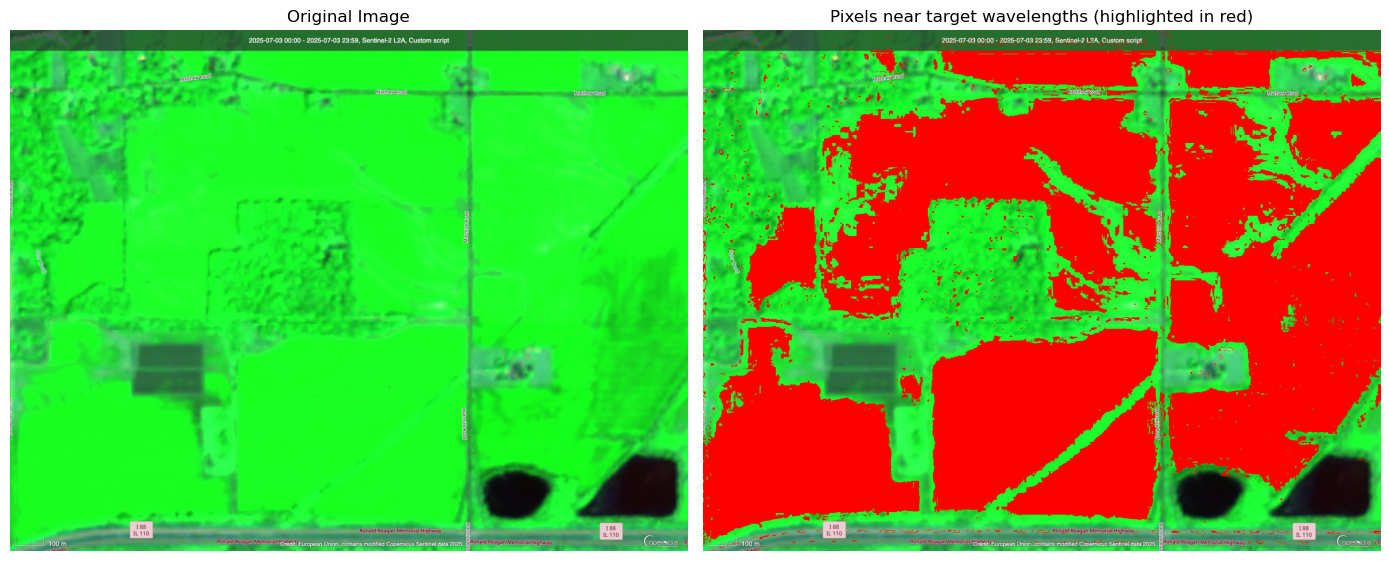

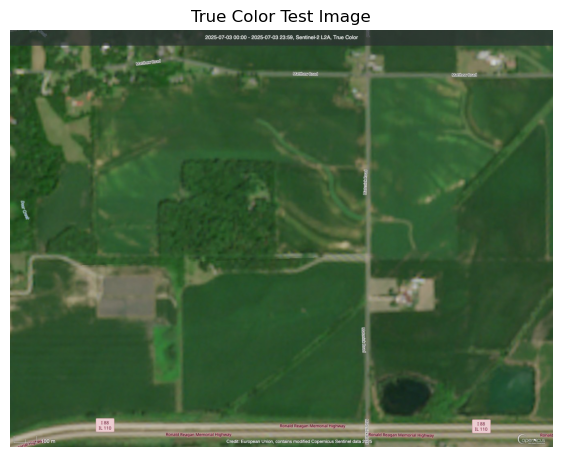

In [38]:
def rgb_to_wavelength(r, g, b):
    """
    Convert RGB values to approximate wavelength in nanometers.
    Simplified approximation using hue-to-wavelength mapping.
    """
    r, g, b = r/255.0, g/255.0, b/255.0
    max_val = max(r, g, b)
    min_val = min(r, g, b)
    diff = max_val - min_val

    if diff == 0:
        h = 0
    elif max_val == r:
        h = (60 * ((g - b)/diff)) % 360
    elif max_val == g:
        h = (60 * ((b - r)/diff) + 120) % 360
    elif max_val == b:
        h = (60 * ((r - g)/diff) + 240) % 360

    # Map hue (0–360) to wavelength (380–750 nm)
    normalized_h = h / 360.0
    wavelength = 380 + (normalized_h * 370)
    return wavelength

# === Define function to highlight pixels based on multiple target wavelengths ===
def highlight_wavelength_pixels(image_path, target_wavelengths, tolerance):
    """
    Highlights pixels in the image that correspond to the given target wavelengths.
    """
    # Load image
    image = io.imread(image_path)

    # Convert RGBA to RGB if needed
    if image.shape[-1] == 4:
        image = image[:, :, :3]

    height, width, _ = image.shape
    highlight_mask = np.zeros((height, width), dtype=bool)

    # Compute wavelength for each pixel and mask pixels within the range
    for y in range(height):
        for x in range(width):
            r, g, b = image[y, x]
            wl = rgb_to_wavelength(r, g, b)
            for target_wavelength in target_wavelengths:
                if abs(wl - target_wavelength) <= tolerance:
                    highlight_mask[y, x] = True
                    break  # Stop checking if one match found

    # Create highlighted image (mark matching pixels in red)
    highlighted_image = image.copy()
    highlighted_image[highlight_mask] = [255, 0, 0]  # Red

    # Count and print result
    count = np.sum(highlight_mask)
    print(f"Pixels near target wavelengths ±{tolerance} nm: {count}")

    # Display images
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(highlighted_image)
    plt.title('Pixels near target wavelengths (highlighted in red)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return highlighted_image, highlight_mask

# === Define list of target wavelengths ===
target_wavelengths = [
    505.48,
    505.21,
    505.23,
    506.01,
    505.77
]

# === Set image path and run the function ===
image_path = "/Users/admin/Downloads/Custom Layer.jpg"  # Replace with your image path
highlighted_image, mask = highlight_wavelength_pixels(image_path, target_wavelengths, tolerance=1.0)

# === Display the true color image within the notebook ===
truecolor_image_path = "/Users/admin/Downloads/True Color Test Image.jpg"
truecolor_image = Image.open(truecolor_image_path)

plt.figure(figsize=(7, 6))
plt.imshow(truecolor_image)
plt.title('True Color Test Image')
plt.axis('off')
plt.show()
